In [191]:
from pyspark.sql.types import *
import pandas as pd
import pyspark 
import os 
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, when,udf, stddev,avg, rank, asc, sum as spark_sum
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [192]:
# Start a Spark session
spark = SparkSession.builder.appName("s33ding").getOrCreate()

# Read the Parquet file into a DataFrame
df = spark.read.parquet("dataset/enem.parquet")
df = df.select(["CO_MUNICIPIO_PROVA", "NOTA_MT_MATEMATICA", "NOTA_LC_LINGUAGENS_E_CODIGOS", "TP_ESCOLA","TP_DEPENDENCIA_ADM_ESC","TP_COR_RACA"])

In [193]:
def categorize_column(df, column_name):
    mean_value = df.agg({column_name: "mean"}).collect()[0][0]
    lowest_value = df.agg({column_name: "min"}).collect()[0][0]
    highest_value = df.agg({column_name: "max"}).collect()[0][0]

    # Define the thresholds for the categories
    very_low_threshold = lowest_value + (mean_value - lowest_value) * 0.25
    low_threshold = lowest_value + (mean_value - lowest_value) * 0.5
    medium_low_threshold = lowest_value + (mean_value - lowest_value) * 0.75
    medium_high_threshold = highest_value - (highest_value - mean_value) * 0.25
    high_threshold = highest_value - (highest_value - mean_value) * 0.5
    very_high_threshold = highest_value - (highest_value - mean_value) * 0.75

    df = df.withColumn(
        column_name,
        when(col(column_name) < very_low_threshold, "very_low")
        .when(col(column_name) < low_threshold, "low")
        .when(col(column_name) < medium_low_threshold, "medium_low")
        .when(col(column_name) < mean_value, "medium")
        .when(col(column_name) < medium_high_threshold, "medium_high")
        .when(col(column_name) < high_threshold, "high")
        .when(col(column_name) < very_high_threshold, "very_high")
        .otherwise("highest")
    )

    return df


# Categorize "NOTA_MT_MATEMATICA" column based on Z-scores
df = categorize_column(df, "NOTA_MT_MATEMATICA")

# Categorize "NOTA_LC_LINGUAGENS_E_CODIGOS" column based on Z-scores
df = categorize_column(df, "NOTA_LC_LINGUAGENS_E_CODIGOS")

In [194]:

drop_values = ['Não informado', 'Não respondeu','Não Respondeu']

# Loop through each column and drop rows with specific values
for column in df.columns:
    if column != 'TP_COR_RACA':
        df = df.filter(~col(column).isin(drop_values))

df.count()
df.show(3)
df.dtypes

+------------------+------------------+----------------------------+---------+----------------------+-----------+
|CO_MUNICIPIO_PROVA|NOTA_MT_MATEMATICA|NOTA_LC_LINGUAGENS_E_CODIGOS|TP_ESCOLA|TP_DEPENDENCIA_ADM_ESC|TP_COR_RACA|
+------------------+------------------+----------------------------+---------+----------------------+-----------+
|           3169901|               low|                 medium_high|  Pública|              Estadual|     Branca|
|           1501402|       medium_high|                 medium_high|  Privada|               Privada|      Parda|
|           2800308|       medium_high|                 medium_high|  Privada|               Privada|      Parda|
+------------------+------------------+----------------------------+---------+----------------------+-----------+
only showing top 3 rows



[('CO_MUNICIPIO_PROVA', 'string'),
 ('NOTA_MT_MATEMATICA', 'string'),
 ('NOTA_LC_LINGUAGENS_E_CODIGOS', 'string'),
 ('TP_ESCOLA', 'string'),
 ('TP_DEPENDENCIA_ADM_ESC', 'string'),
 ('TP_COR_RACA', 'string')]

In [195]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import monotonically_increasing_id



lst_cols = ["CO_MUNICIPIO_PROVA", "NOTA_MT_MATEMATICA", "NOTA_LC_LINGUAGENS_E_CODIGOS", "TP_ESCOLA", "TP_DEPENDENCIA_ADM_ESC"]
selected_cols = lst_cols + ["TP_COR_RACA"]
df_selected = df.select(selected_cols)

# Apply StringIndexer to encode string columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_selected) for column in selected_cols]
indexed_df = df_selected
for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)

assembler = VectorAssembler(inputCols=[column+"_index" for column in lst_cols], outputCol="features")
indexed_df = assembler.transform(indexed_df)


In [196]:
indexed_df = indexed_df.withColumn("pk", monotonically_increasing_id())

# Assuming you have the 'indexed_df' DataFrame with 'TP_COR_RACA' and 'TP_COR_RACA_index' columns
# Create a temporary view for the indexed DataFrame
indexed_df.createOrReplaceTempView("indexed_view")

# Run a SQL query to match 'TP_COR_RACA' labels with 'TP_COR_RACA_index'
query = """
SELECT TP_COR_RACA, TP_COR_RACA_index
FROM (
    SELECT TP_COR_RACA, TP_COR_RACA_index, ROW_NUMBER() OVER (PARTITION BY TP_COR_RACA_index ORDER BY TP_COR_RACA) AS rn
    FROM indexed_view
) t
WHERE rn = 1
"""
target_lable = spark.sql(query)
target_lable.show()
target_lable.write.mode("overwrite").json("models/tp_cor_raca_lable_json/dct_data_classication.json")

+-------------+-----------------+
|  TP_COR_RACA|TP_COR_RACA_index|
+-------------+-----------------+
|       Branca|              0.0|
|        Parda|              1.0|
|        Preta|              2.0|
|      Amarela|              3.0|
|Não declarado|              4.0|
|     Indígena|              5.0|
+-------------+-----------------+



In [197]:
train_data, test_data = indexed_df.randomSplit([0.8, 0.2], seed=42)


In [198]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [199]:
train_data, test_data = indexed_df.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="TP_COR_RACA_index", featuresCol="features", maxBins=3000)
rf_model = rf.fit(train_data)

lr = LogisticRegression(labelCol="TP_COR_RACA_index", featuresCol="features")
lr_model = lr.fit(train_data)

dt = DecisionTreeClassifier(labelCol="TP_COR_RACA_index", featuresCol="features", maxBins=3000)
dt_model = dt.fit(train_data)

23/06/17 21:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
23/06/17 21:32:22 WARN DAGScheduler: Broadcasting large task binary with size 1766.1 KiB


In [200]:
evaluator = MulticlassClassificationEvaluator(labelCol="TP_COR_RACA_index", metricName="accuracy")

In [201]:
rf_predictions = rf_model.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)

lr_predictions = lr_model.transform(test_data)
lr_accuracy = evaluator.evaluate(lr_predictions)

dt_predictions = dt_model.transform(test_data)
dt_accuracy = evaluator.evaluate(dt_predictions)

23/06/17 21:32:39 WARN DAGScheduler: Broadcasting large task binary with size 1500.2 KiB


In [203]:
from pyspark.sql.functions import col

# Create temporary views for the predictions
lr_predictions.createOrReplaceTempView("lr_predictions")
dt_predictions.createOrReplaceTempView("dt_predictions")
rf_predictions.createOrReplaceTempView("rf_predictions")

# Join the predictions using the primary key (pk) column
joined_predictions = spark.sql("""
    SELECT lr_predictions.features, lr_predictions.prediction AS lr_prediction,
           dt_predictions.prediction AS dt_prediction, rf_predictions.prediction AS rf_prediction,
           lr_predictions.TP_COR_RACA_index
    FROM lr_predictions
    JOIN dt_predictions ON lr_predictions.pk = dt_predictions.pk
    JOIN rf_predictions ON lr_predictions.pk = rf_predictions.pk
    ORDER BY lr_predictions.pk
""")


# Get a sample from the joined_predictions DataFrame
sample_joined_predictions = joined_predictions.sample(fraction=0.1, seed=42)

# Save the sample as a Parquet file
sample_joined_predictions.write.mode('overwrite').parquet('data_for_dashboards/models/tp_cor_raca/joined_predictions')

# Show the joined predictions
joined_predictions.show()

23/06/17 21:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1489.8 KiB
23/06/17 21:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1668.8 KiB
23/06/17 21:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1676.3 KiB
23/06/17 21:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1845.9 KiB
23/06/17 21:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1489.8 KiB
23/06/17 21:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1668.4 KiB


+--------------------+-------------+-------------+-------------+-----------------+
|            features|lr_prediction|dt_prediction|rf_prediction|TP_COR_RACA_index|
+--------------------+-------------+-------------+-------------+-----------------+
|(5,[0,1],[228.0,3...|          1.0|          1.0|          1.0|              0.0|
|[20.0,0.0,0.0,1.0...|          0.0|          0.0|          0.0|              1.0|
|[2.0,0.0,0.0,1.0,...|          0.0|          0.0|          0.0|              1.0|
|[27.0,0.0,0.0,1.0...|          0.0|          0.0|          0.0|              4.0|
|[52.0,3.0,4.0,0.0...|          1.0|          1.0|          1.0|              0.0|
| (5,[0,4],[3.0,1.0])|          0.0|          0.0|          0.0|              1.0|
|     (5,[0],[491.0])|          0.0|          0.0|          0.0|              0.0|
|(5,[0,1],[42.0,1.0])|          0.0|          1.0|          1.0|              1.0|
|[129.0,0.0,0.0,1....|          0.0|          0.0|          0.0|              1.0|
|[79

In [219]:
# Define the prediction columns and corresponding evaluator names
prediction_columns = ['lr_prediction', 'dt_prediction', 'rf_prediction']
evaluator_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# Define the schema for the evaluation results
schema = StructType([
    StructField('Model', StringType(), nullable=False),
    StructField('Precision', DoubleType(), nullable=False),
    StructField('Recall', DoubleType(), nullable=False)
])

# Create an empty DataFrame with the predefined schema
evaluation_df = spark.createDataFrame([], schema)

# Create a MulticlassClassificationEvaluator for precision and recall
evaluator = MulticlassClassificationEvaluator(labelCol='TP_COR_RACA_index')

# Calculate precision and recall for each prediction column
for column, model_name in zip(prediction_columns, evaluator_names):
    precision = evaluator.setMetricName('weightedPrecision').setPredictionCol(column).evaluate(joined_predictions)
    recall = evaluator.setMetricName('weightedRecall').setPredictionCol(column).evaluate(joined_predictions)
    evaluation_df = evaluation_df.union(spark.createDataFrame([(model_name, precision, recall)], schema))

# Show the evaluation results
evaluation_df.show(truncate=False)

23/06/17 21:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1488.0 KiB
23/06/17 21:53:32 WARN DAGScheduler: Broadcasting large task binary with size 1547.3 KiB
23/06/17 21:53:33 WARN DAGScheduler: Broadcasting large task binary with size 1554.9 KiB
23/06/17 21:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1525.3 KiB
23/06/17 21:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1488.0 KiB
23/06/17 21:53:35 WARN DAGScheduler: Broadcasting large task binary with size 1547.3 KiB
23/06/17 21:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1554.9 KiB
23/06/17 21:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1525.3 KiB


+-------------------+-------------------+------------------+
|Model              |Precision          |Recall            |
+-------------------+-------------------+------------------+
|Logistic Regression|0.46774342421375953|0.5421754171754172|
|Decision Tree      |0.4975591452036772 |0.5630850630850631|
|Random Forest      |0.48641314615791387|0.5597781847781849|
+-------------------+-------------------+------------------+



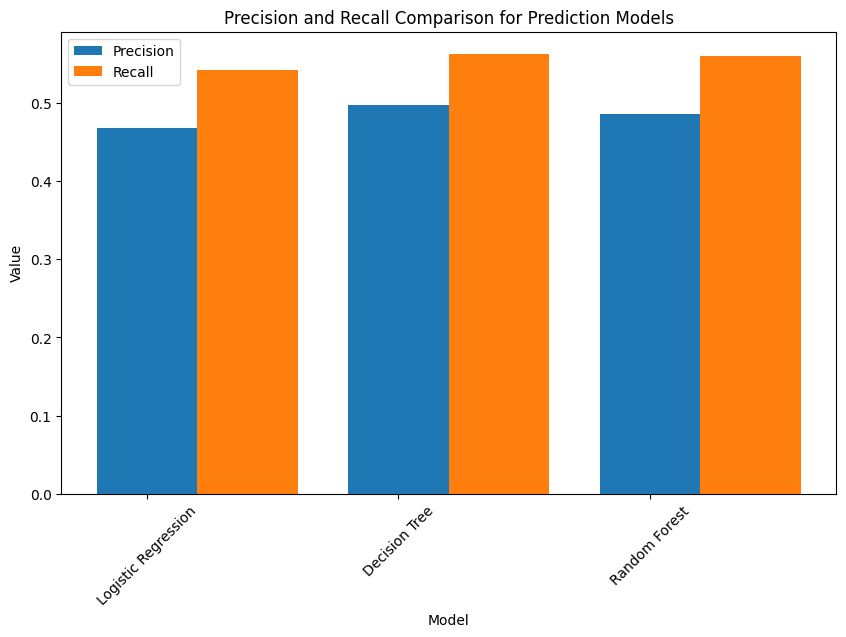

In [220]:
import matplotlib.pyplot as plt

# Convert the evaluation DataFrame to Pandas for plotting
evaluation_pd = evaluation_df.toPandas()

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the x-axis labels and positions
x_labels = evaluation_pd['Model']
x_pos = range(len(x_labels))

# Plot the precision and recall as grouped bars
plt.bar(x_pos, evaluation_pd['Precision'], width=0.4, align='center', label='Precision')
plt.bar([pos + 0.4 for pos in x_pos], evaluation_pd['Recall'], width=0.4, align='center', label='Recall')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Precision and Recall Comparison for Prediction Models')
plt.xticks(x_pos, x_labels, rotation=45)
plt.legend()

# Show the plot
plt.show()


In [212]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming you have the DataFrame containing the predictions
joined_predictions.createOrReplaceTempView("predictions_view")

# Run a SQL query to calculate the accuracy for each prediction column
query = """
SELECT 
    AVG(CASE WHEN lr_prediction = TP_COR_RACA_index THEN 1.0 ELSE 0.0 END) AS lr_accuracy,
    AVG(CASE WHEN dt_prediction = TP_COR_RACA_index THEN 1.0 ELSE 0.0 END) AS dt_accuracy,
    AVG(CASE WHEN rf_prediction = TP_COR_RACA_index THEN 1.0 ELSE 0.0 END) AS rf_accuracy
FROM predictions_view
"""
result = spark.sql(query)

# Extract accuracy values from the result DataFrame
accuracy_values = result.first()

# Print the accuracy values for each prediction column
print("Accuracy for Logistic Regression: {:.2%}".format(accuracy_values['lr_accuracy']))
print("Accuracy for Decision Tree: {:.2%}".format(accuracy_values['dt_accuracy']))
print("Accuracy for Random Forest: {:.2%}".format(accuracy_values['rf_accuracy']))


23/06/17 21:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1489.8 KiB
23/06/17 21:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB


Accuracy for Logistic Regression: 54.22%
Accuracy for Decision Tree: 56.31%
Accuracy for Random Forest: 55.98%


In [208]:
# Assuming you have the DataFrame containing the predictions and 'TP_COR_RACA_index' column
joined_predictions.createOrReplaceTempView("predictions_view")

# Run a SQL query to calculate the total matches for each prediction from each model
query = """
SELECT SUM(CASE WHEN lr_prediction = TP_COR_RACA_index THEN 1 ELSE 0 END) AS lr_match_count,
       SUM(CASE WHEN dt_prediction = TP_COR_RACA_index THEN 1 ELSE 0 END) AS dt_match_count,
       SUM(CASE WHEN rf_prediction = TP_COR_RACA_index THEN 1 ELSE 0 END) AS rf_match_count,
       COUNT(*) AS total_rows
FROM predictions_view
"""
result = spark.sql(query)

# Show the result
result.show()

23/06/17 21:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1489.8 KiB
23/06/17 21:40:39 WARN DAGScheduler: Broadcasting large task binary with size 1668.6 KiB


+--------------+--------------+--------------+----------+
|lr_match_count|dt_match_count|rf_match_count|total_rows|
+--------------+--------------+--------------+----------+
|         10657|         11068|         11003|     19656|
+--------------+--------------+--------------+----------+



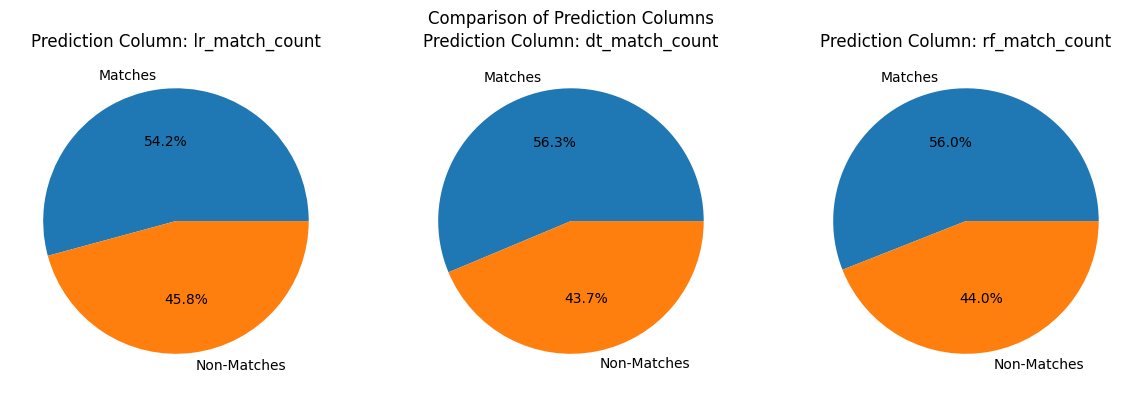

In [211]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrame containing the prediction counts
prediction_counts = result.toPandas()

# Get the model names and match counts
models = ['lr_match_count', 'dt_match_count', 'rf_match_count']

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Create a pie chart for each prediction column
for i, model in enumerate(models):
    match_count = prediction_counts.iloc[0][model]
    non_match_count = prediction_counts.iloc[0]['total_rows'] - match_count
    counts = [match_count, non_match_count]
    labels = ['Matches', 'Non-Matches']

    # Plot the pie chart
    axes[i].pie(counts, labels=labels, autopct='%1.1f%%')
    axes[i].set_title(f"Prediction Column: {model}")

# Set the overall title for the subplots
fig.suptitle("Comparison of Prediction Columns")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


In [214]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator for precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='TP_COR_RACA_index', predictionCol='lr_prediction', metricName='weightedPrecision')

# Calculate precision
precision = precision_evaluator.evaluate(joined_predictions)

# Create a MulticlassClassificationEvaluator for recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='TP_COR_RACA_index', predictionCol='lr_prediction', metricName='weightedRecall')

# Calculate recall
recall = recall_evaluator.evaluate(joined_predictions)

# Print the evaluation metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Precision: 0.4677
Recall: 0.5422


In [ ]:

spark.stop()

In [ ]:
# Specify the path to save the model
model_path = "models/tp_cor_raca/random_forest"

# Save the Random Forest model, overwriting if the model already exists
rf_model.write().overwrite().save(model_path)


In [ ]:
# Access the predicted TP_COR_RACA values
predicted_values = rf_predictions.select("prediction").collect()

# Print the predicted TP_COR_RACA values
for row in predicted_values:
    print("Predicted TP_COR_RACA:", row.prediction)

23/06/17 01:42:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


Predicted TP_COR_RACA: 1.0
Predicted TP_COR_RACA: 1.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
Predicted TP_COR_RACA: 0.0
P